In [1]:
import pandas as pd
import numpy as np
import itertools
from tqdm import tqdm
import pickle

# Import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler, 
                                   OneHotEncoder)
from sklearn.ensemble import RandomForestClassifier

from yellowbrick.classifier import classification_report
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier.rocauc import roc_auc


# Importing the database

In [2]:
train = pd.read_csv('./train.csv')
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Creating the training and testing pipeline

In [3]:
X = train.drop(columns=['Survived'])
y = train['Survived']

cols = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']
X = X[cols]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print("#"*30)
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (623, 5)
y_train shape: (623,)
##############################
X_test shape: (268, 5)
y_test shape: (268,)


In [4]:
num_vars = ['Age', 'Fare']
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='mean')), 
           ("scaler", StandardScaler())]
)

cat_vars = ['Pclass', 'Sex', 'Embarked']
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='most_frequent')),
           ("ohe", OneHotEncoder(handle_unknown="ignore", drop='first'))])
    
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_vars),
        ("cat", categorical_transformer, cat_vars)
    ]
)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Pclass', 'Sex', 'Embarked'])])

In [5]:
clf=RandomForestClassifier(n_estimators=5, 
                           criterion="entropy",
                           random_state=42,
                           n_jobs=-1,
                           max_depth=3,
                           class_weight="balanced")
clf

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3, n_estimators=5, n_jobs=-1, random_state=42)

In [6]:
# build pipeline
pipe = Pipeline([('preprocessor', preprocessor), 
                 ('clf', clf)])

pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=3,
                                        n_estimators=5, n_jobs=-1,
                                        random_state=42))])

In [7]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=3,
                                        n_estimators=5, n_jobs=-1,
                                        random_state=42))])

## Results

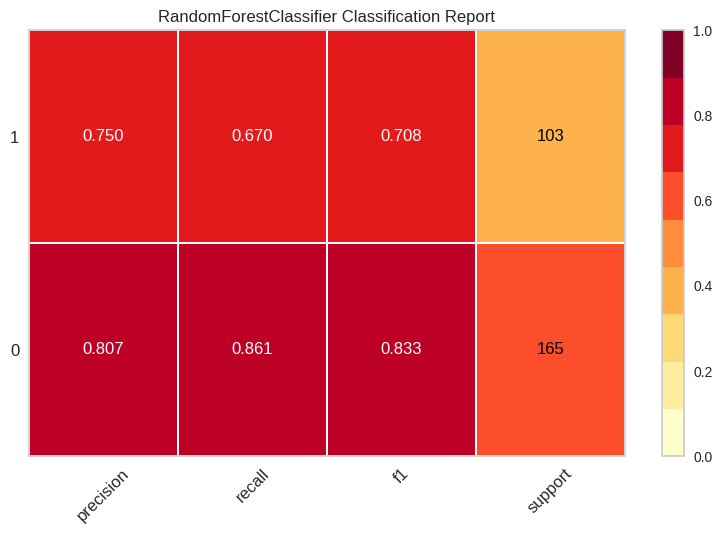

In [8]:
_ = classification_report(
    pipe, 
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    support=True)

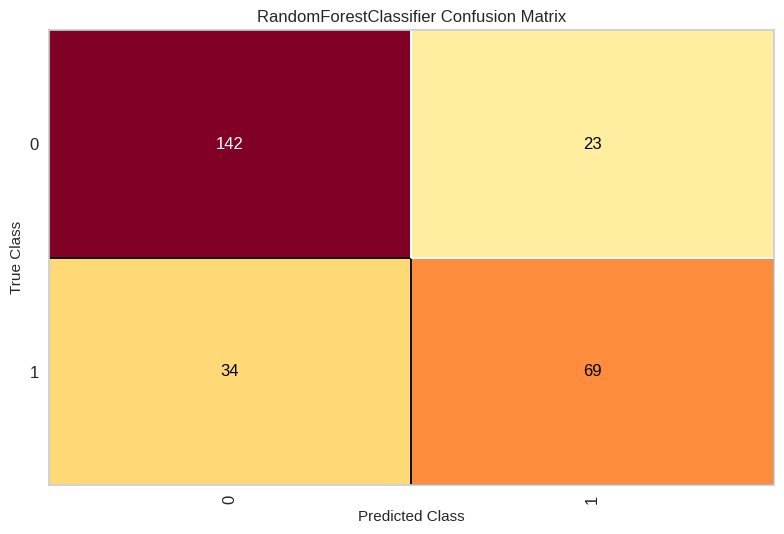

In [9]:
_ = confusion_matrix(
    pipe,
    X_train, 
    y_train, 
    X_test, 
    y_test
)

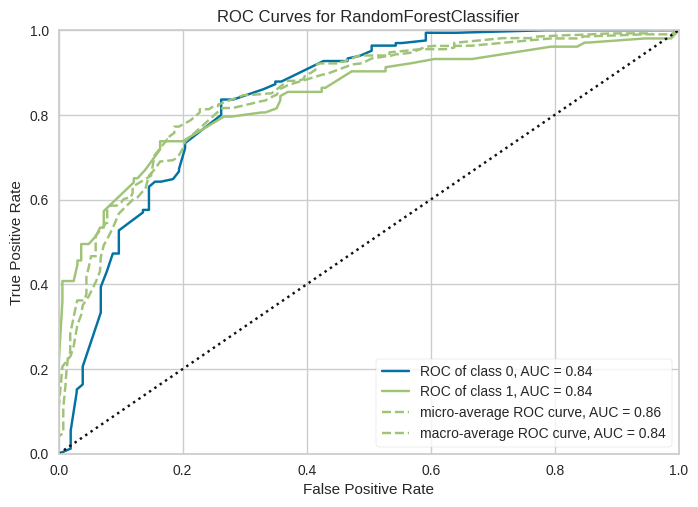

In [10]:
_ = roc_auc(pipe, 
        X_train, 
        y_train, 
        X_test, 
        y_test)

## Save model and other informations...

In [11]:
with open(r"../models/model.pickle", "wb") as model:
    pickle.dump(pipe, model)

In [12]:
X

,Pclass,Sex,Age,Fare,Embarked
0,3,male,22.0,7.2500,S
1,1,female,38.0,71.2833,C
2,3,female,26.0,7.9250,S
3,1,female,35.0,53.1000,S
4,3,male,35.0,8.0500,S
...,...,...,...,...,...
886,2,male,27.0,13.0000,S
887,1,female,19.0,30.0000,S
888,3,female,NaN,23.4500,S
889,1,male,26.0,30.0000,C


In [13]:
X['Pclass'].unique()

array([3, 1, 2])

In [14]:
X['Sex'].unique()

array(['male', 'female'], dtype=object)

In [15]:
X['Age'].min(),X['Age'].max()

(0.42, 80.0)

In [16]:
X['Fare'].min(),X['Fare'].max()

(0.0, 512.3292)

In [17]:
X['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)